In [2]:
#%% Importamos las librerias
from shu_dataset import ModelShuDataset
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io as sio

In [3]:
#%% Leemos los datos y adaptamos la base de datos para obtener las epocas acondicionadas
path_root = "/home/bruno/Academico/Doctorado/Neuro_Fairness/Shu_Dataset/"
dataset_field="B_Dataset_Preprocessing/"
save_figures = True
figures_path_root = path_root + "Processing_Figures/"
save_path = path_root + 'C_Dataset_CSP/'
participants=["sub-001","sub-002","sub-003","sub-004","sub-005",
              "sub-006","sub-007","sub-008","sub-009","sub-010",
              "sub-011","sub-012","sub-013","sub-014","sub-015",
              "sub-016","sub-017","sub-018","sub-019","sub-020",
              "sub-021","sub-022","sub-023","sub-024","sub-025"]

sessions=["ses-01","ses-02","ses-03","ses-04","ses-05"]

In [3]:
#%% Cargamos los datos
registers = ModelShuDataset()
registers.load_registers(path = path_root + dataset_field, participants = participants, sessions = sessions)

NameError: name 'ModelShuDataset' is not defined

In [4]:
path = path_root + dataset_field
genders=[]
registers={}
participants = participants
sessions = sessions
for participant in participants:
    flag_participant=True
    registers[participant] = {}
    for session in sessions: 
        database_path= path + participant +"/"
        data_path=participant+"_"+session+"_task_motorimagery_eeg_preprocessing.mat"
        data=sio.loadmat(database_path + data_path)
        registers[participant][session]= {}
        registers[participant][session]['data'] = data['data']
        registers[participant][session]['labels_trials'] = np.squeeze(data['labels_trials'])
        if flag_participant:
            registers[participant]['group_medidator'] = data['group_medidator']
            registers[participant]['gender'] = data['gender']
            genders.append(data['gender'])
            registers[participant]['id_participant'] = data['id_participant']
            registers[participant]['sfreq'] = data['sfreq']
            ch_names = data['ch_names']
            it=0
            for ch in data['ch_names']:
                if ' ' in ch:
                    ch_names[it]=ch[:-1]
                it+=1
            registers[participant]['ch_names']=ch_names 
            registers[participant]['age'] = data['age']
            registers[participant]['n_epochs'] = data['data'].shape[0]
            registers[participant]['n_samples'] = data['data'].shape[2]
            registers[participant]['n_chans'] = data['data'].shape[1]
            flag_participant = False

In [5]:
from sklearn.model_selection import StratifiedKFold , train_test_split

In [6]:
train_participants, validation_participants = train_test_split(np.array(participants),train_size= 0.2,
                                                         test_size= 0.8,
                                                         stratify= np.array(genders))

In [7]:
data_train = np.zeros((1,32,1000))
labels_train = np.zeros((1))
for train_participant in train_participants:
    data_train = np.concatenate((data_train,
                                        registers[train_participant]["ses-01"]['data'],
                                        registers[train_participant]["ses-02"]['data'],
                                        registers[train_participant]["ses-03"]['data'],
                                        registers[train_participant]["ses-04"]['data'],
                                        registers[train_participant]["ses-05"]['data']),axis=0)     
    labels_train =np.concatenate((labels_train,
                                        registers[train_participant]["ses-01"]['labels_trials'],
                                        registers[train_participant]["ses-02"]['labels_trials'],
                                        registers[train_participant]["ses-03"]['labels_trials'],
                                        registers[train_participant]["ses-04"]['labels_trials'],
                                        registers[train_participant]["ses-05"]['labels_trials']))  
data_train = data_train[1:,:,:]
labels_train = labels_train[1:]

In [9]:
from mne.decoding import CSP

In [10]:
csp = CSP(n_components = 6,reg = 'oas' )
csp.fit(data_train, labels_train)

Computing rank from data with rank=None
    Using tolerance 19 (2.2e-16 eps * 32 dim * 2.6e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 32 dim * 2.6e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using OAS
Done.
{'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 6,
 'norm_trace': False,
 'rank': None,
 'reg': 'oas',
 'transform_into': 'average_power'}


CSP(None)

In [11]:
for val_participant in validation_participants:
    registers[val_participant]["ses-01"]['data_csp']=csp.transform(registers[val_participant]["ses-01"]['data'])
    registers[val_participant]["ses-02"]['data_csp']=csp.transform(registers[val_participant]["ses-02"]['data'])
    registers[val_participant]["ses-03"]['data_csp']=csp.transform(registers[val_participant]["ses-03"]['data'])
    registers[val_participant]["ses-04"]['data_csp']=csp.transform(registers[val_participant]["ses-04"]['data'])
    registers[val_participant]["ses-05"]['data_csp']=csp.transform(registers[val_participant]["ses-05"]['data'])
            
for train_participant in train_participants:
    registers[train_participant]["ses-01"]['data_csp']=csp.transform(registers[train_participant]["ses-01"]['data'])
    registers[train_participant]["ses-02"]['data_csp']=csp.transform(registers[train_participant]["ses-02"]['data'])
    registers[train_participant]["ses-03"]['data_csp']=csp.transform(registers[train_participant]["ses-03"]['data'])
    registers[train_participant]["ses-04"]['data_csp']=csp.transform(registers[train_participant]["ses-04"]['data'])
    registers[train_participant]["ses-05"]['data_csp']=csp.transform(registers[train_participant]["ses-05"]['data'])

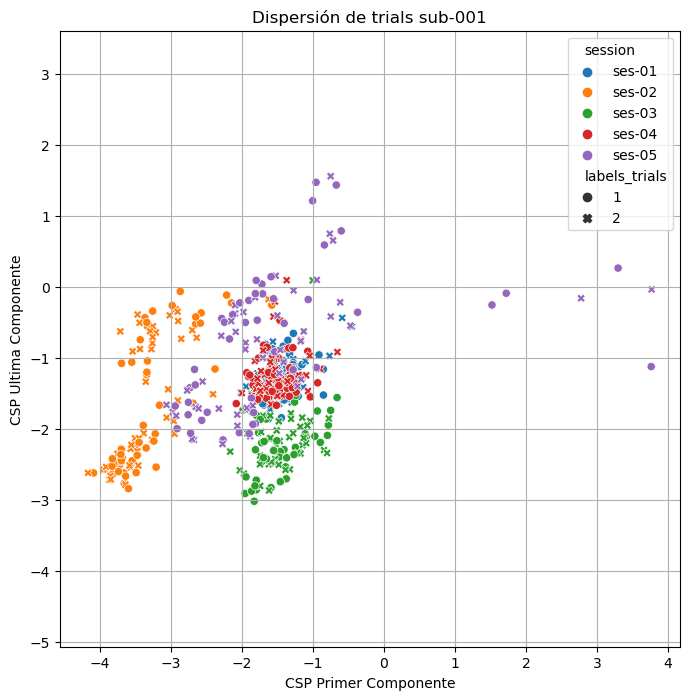

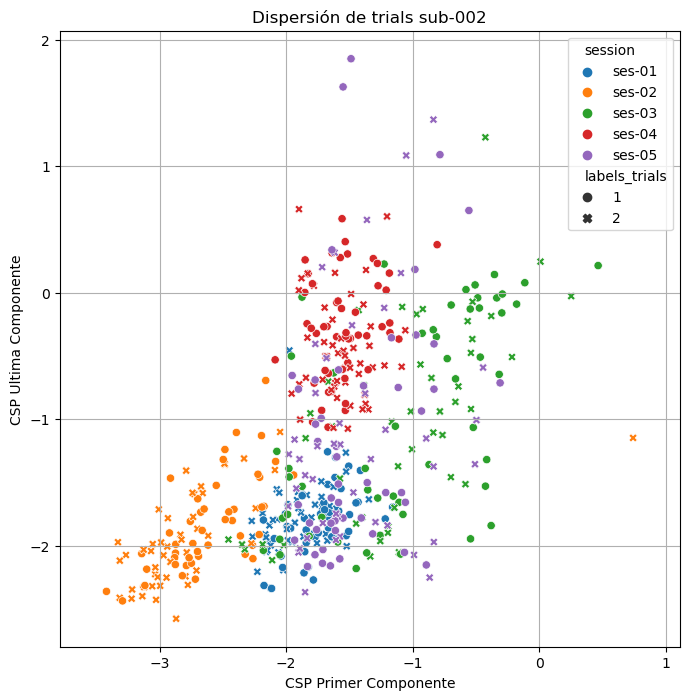

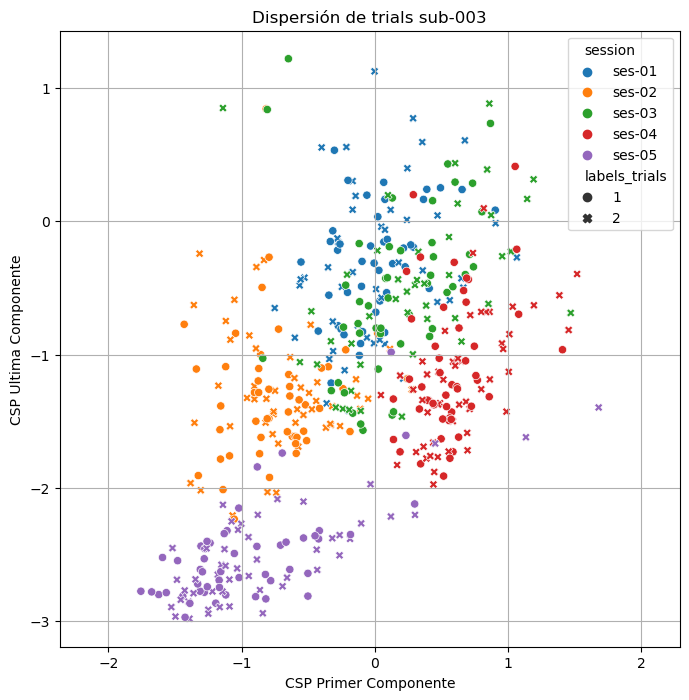

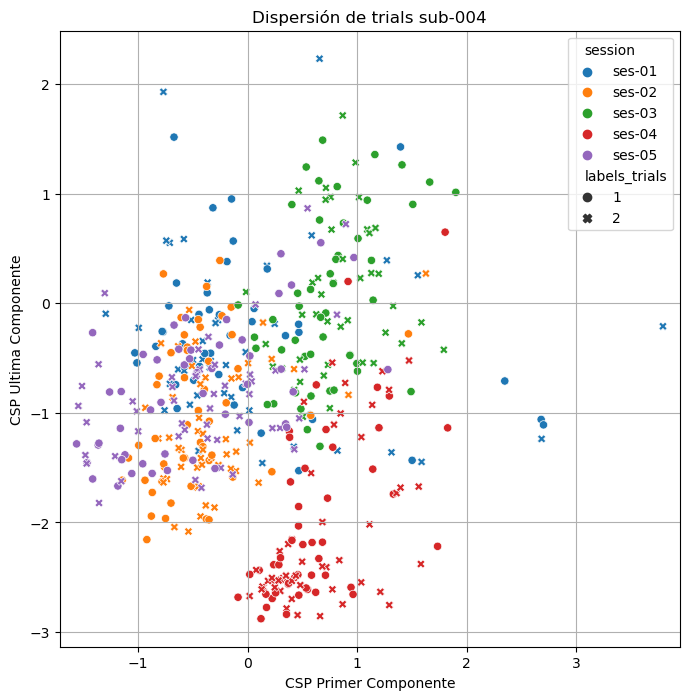

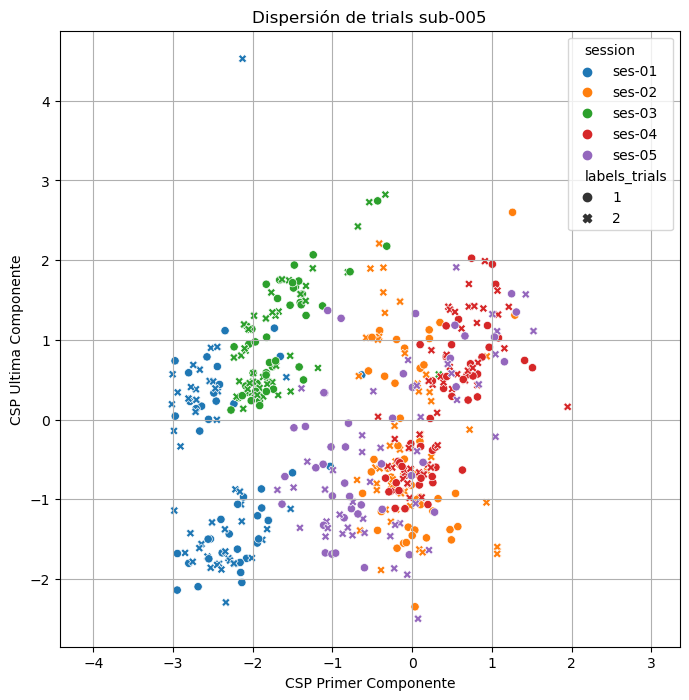

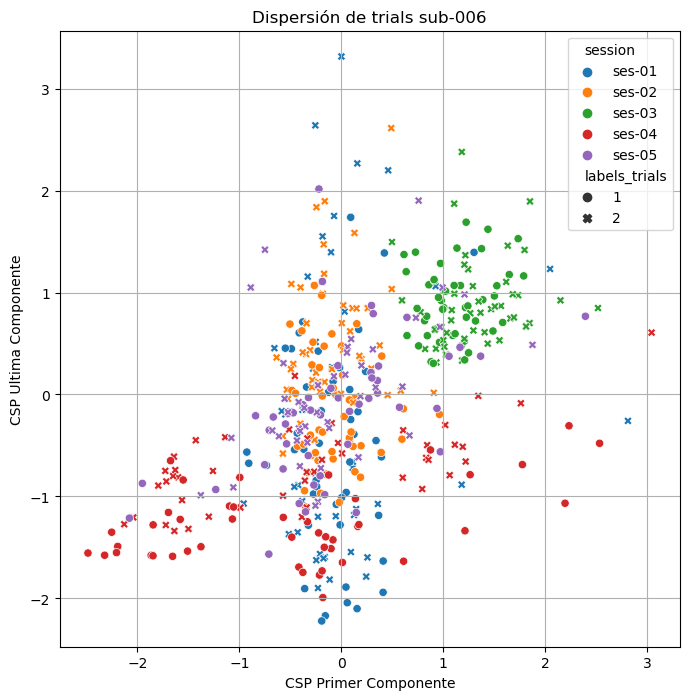

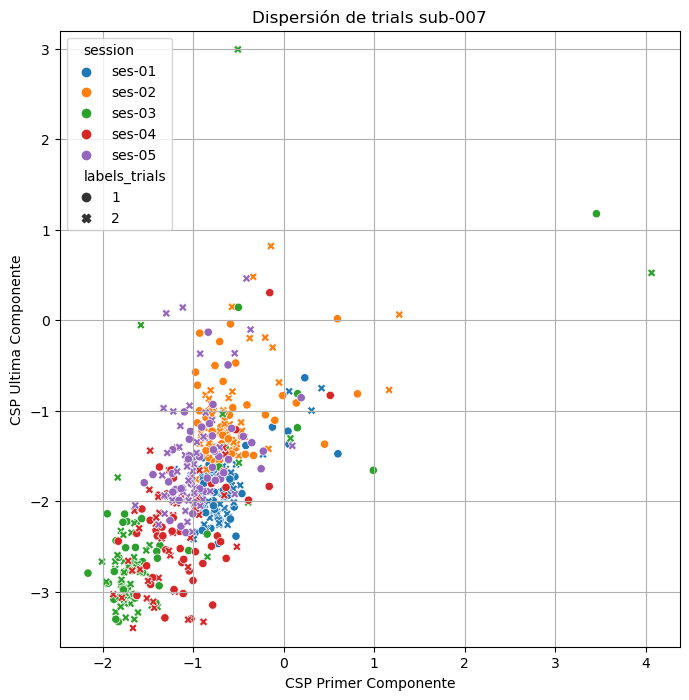

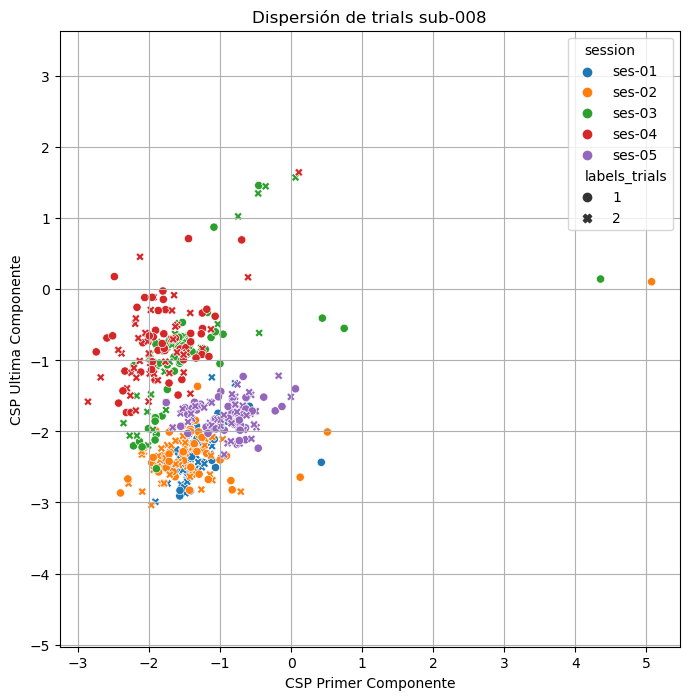

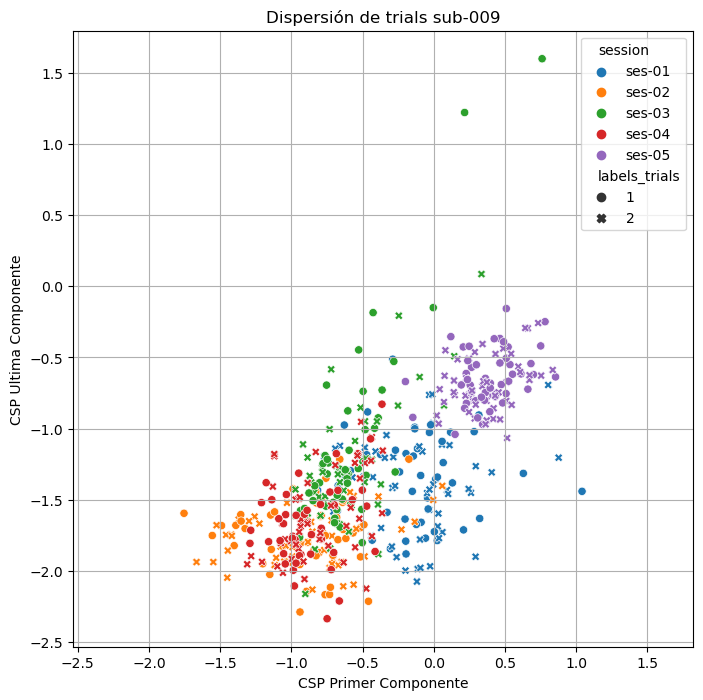

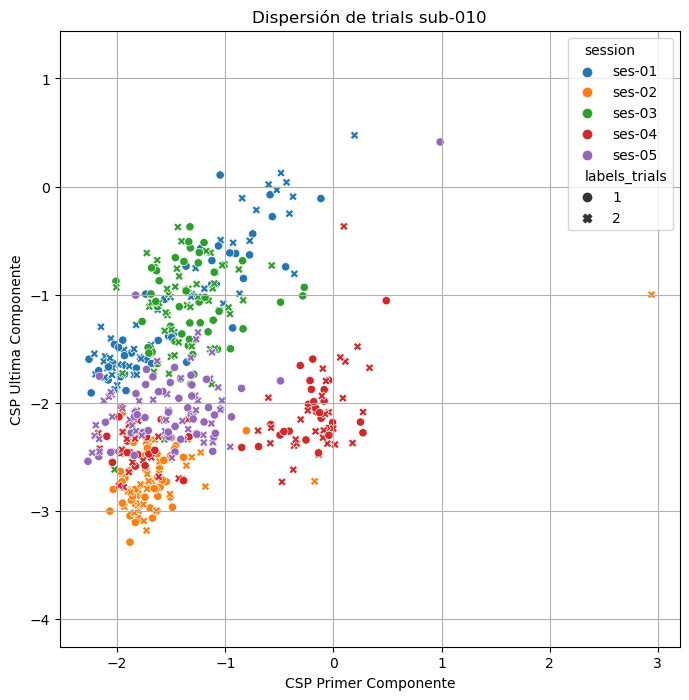

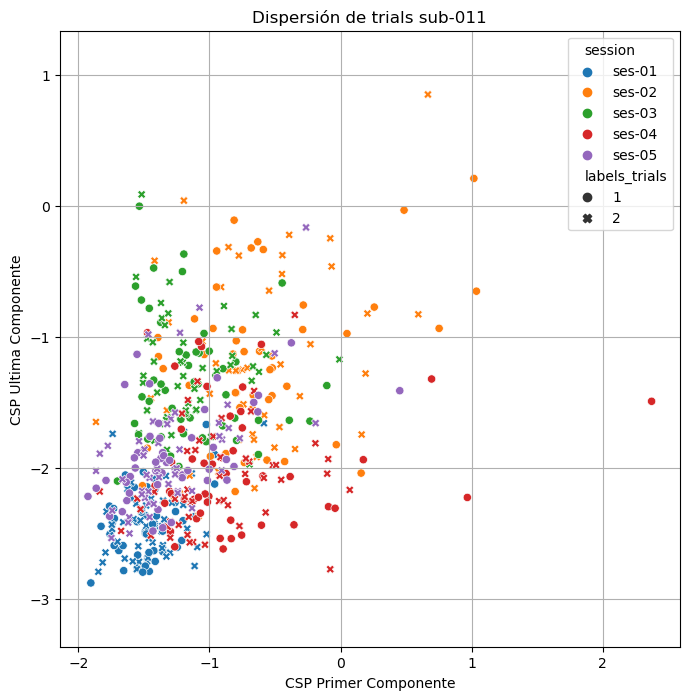

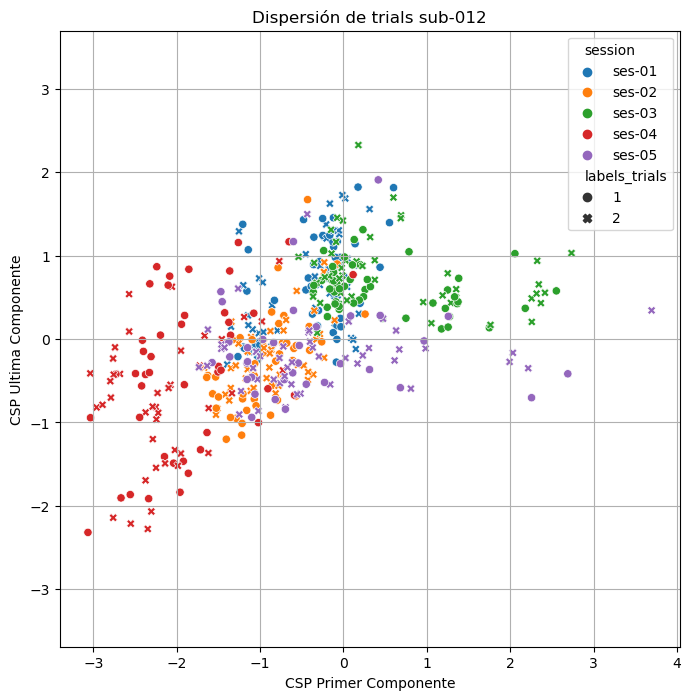

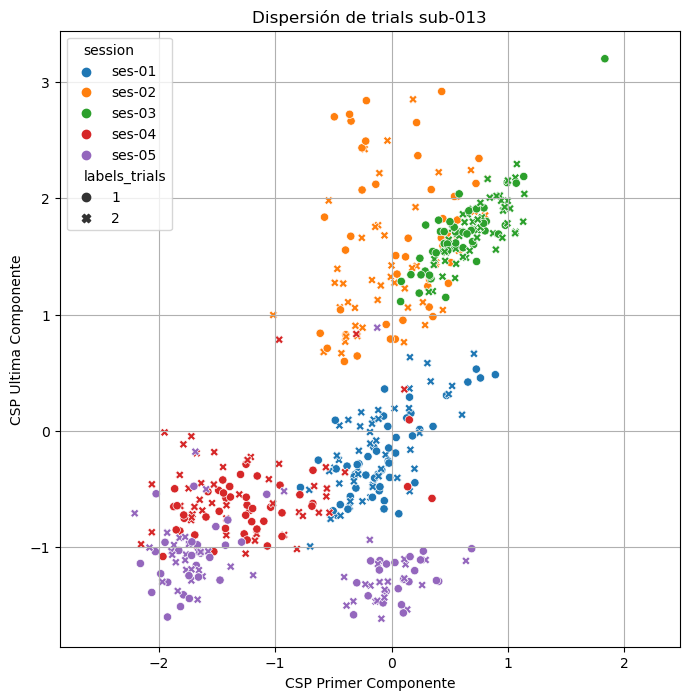

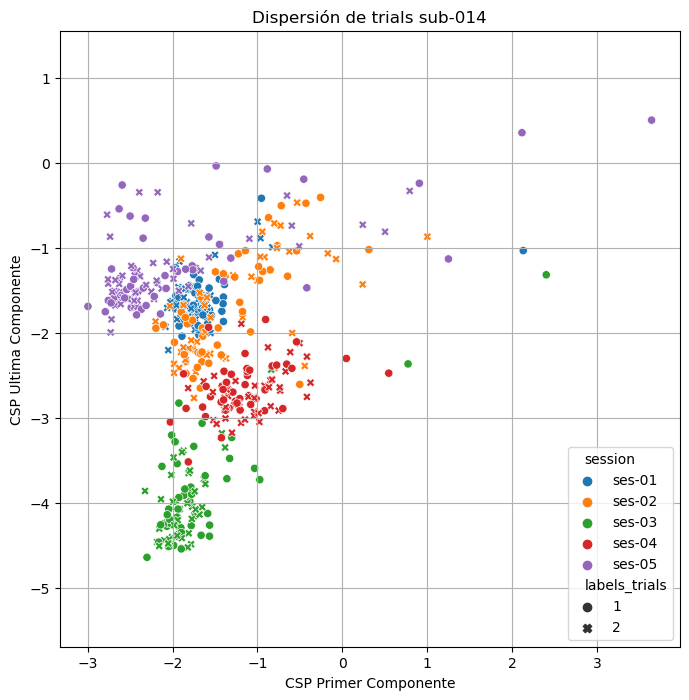

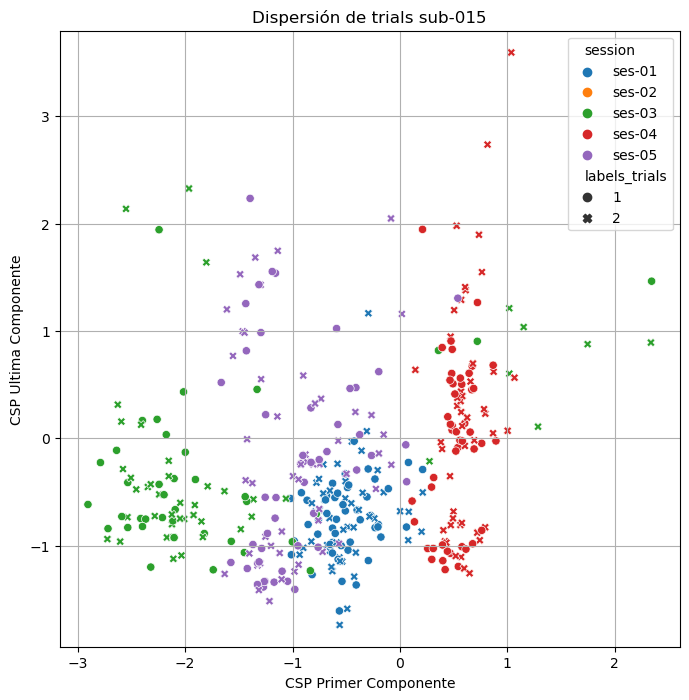

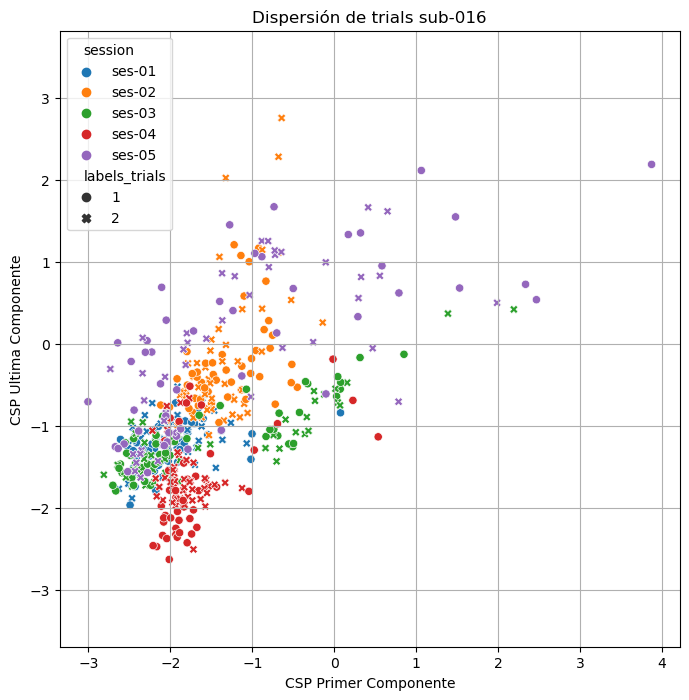

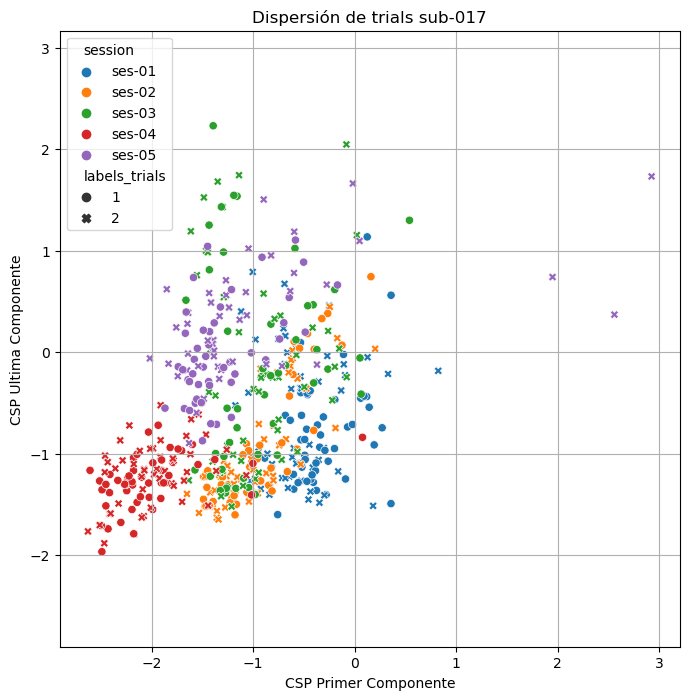

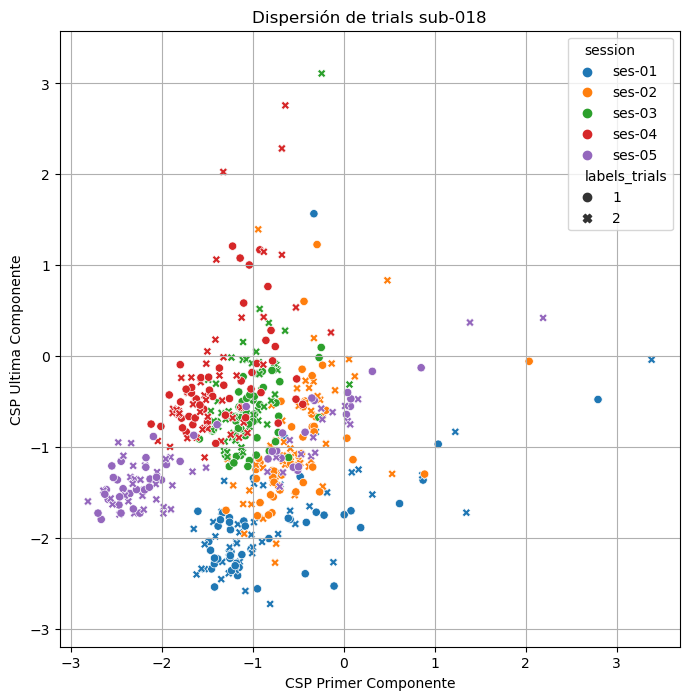

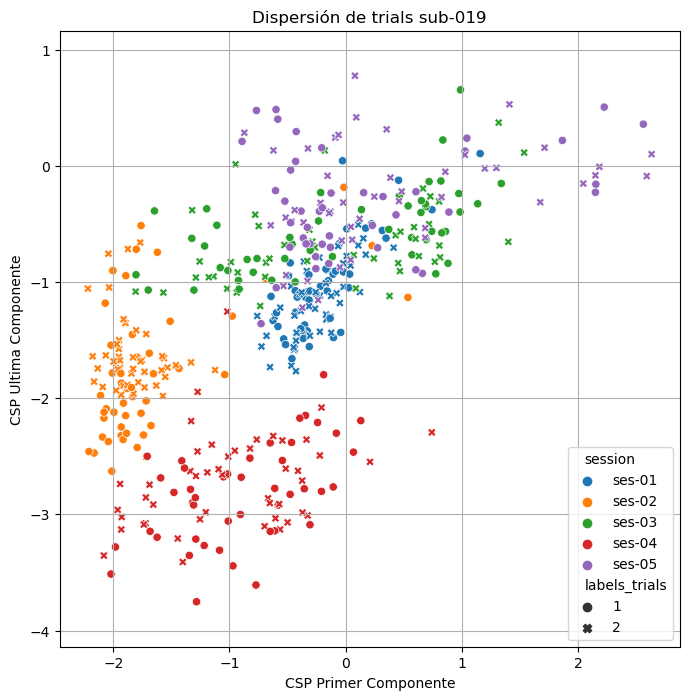

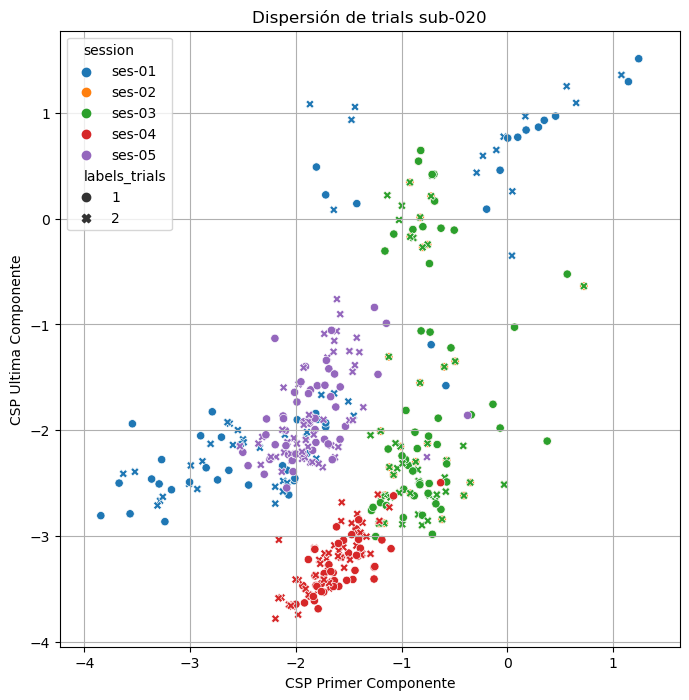

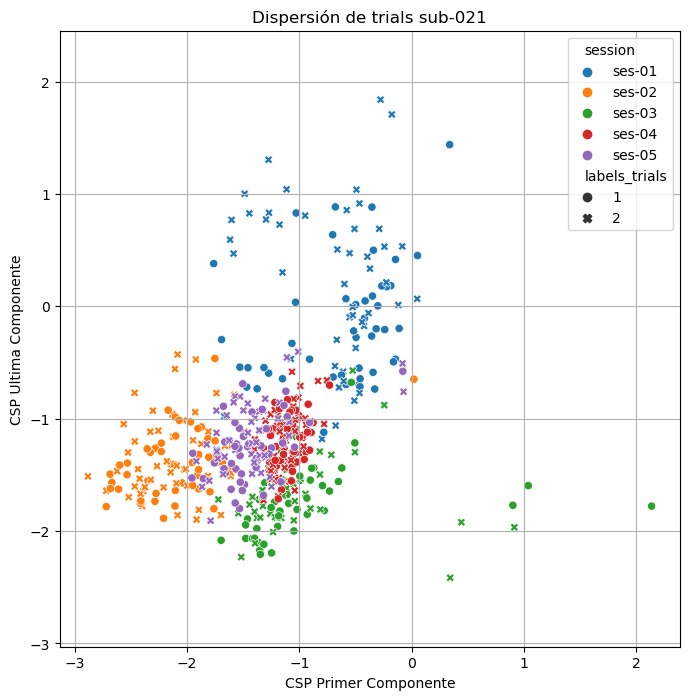

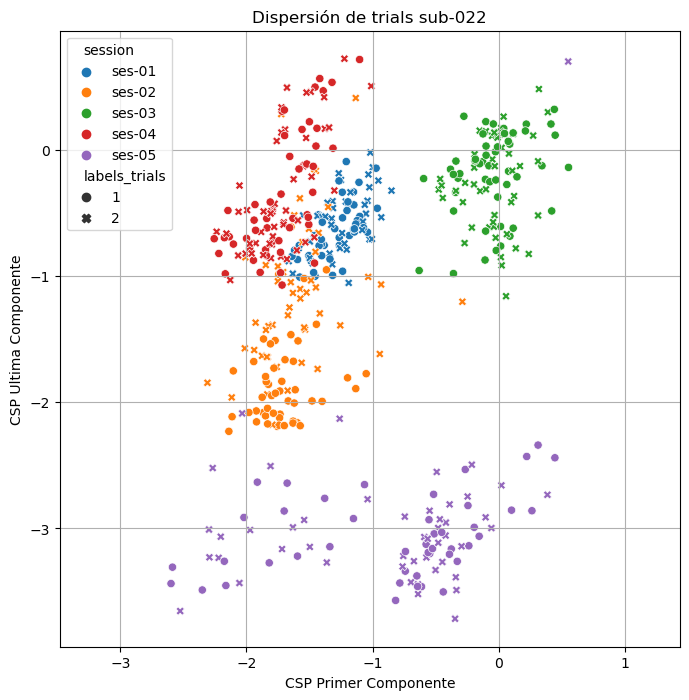

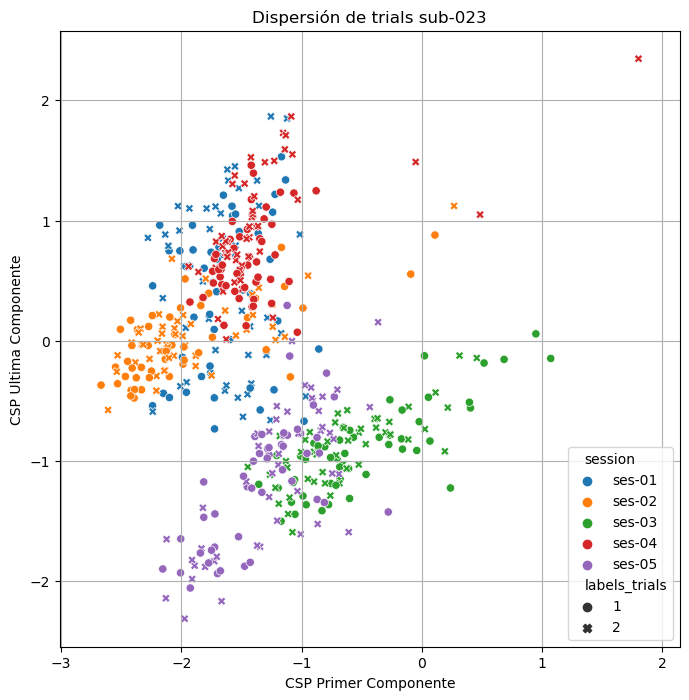

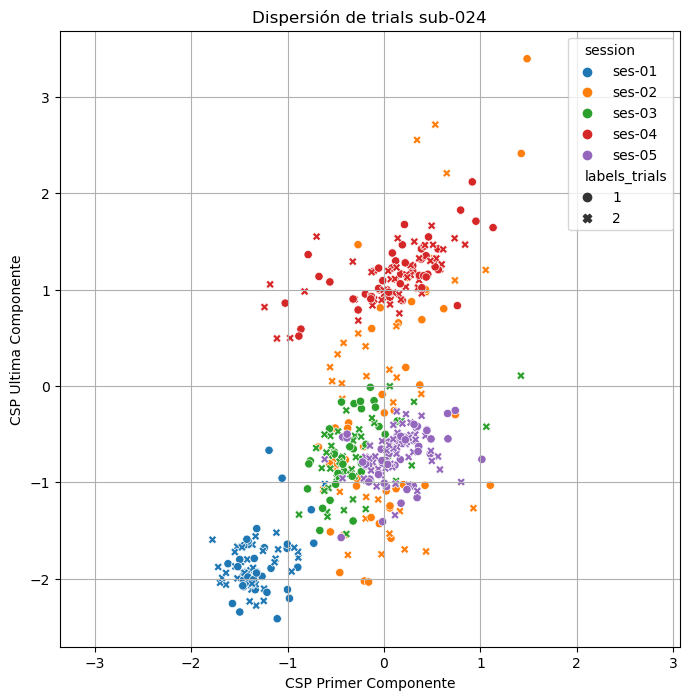

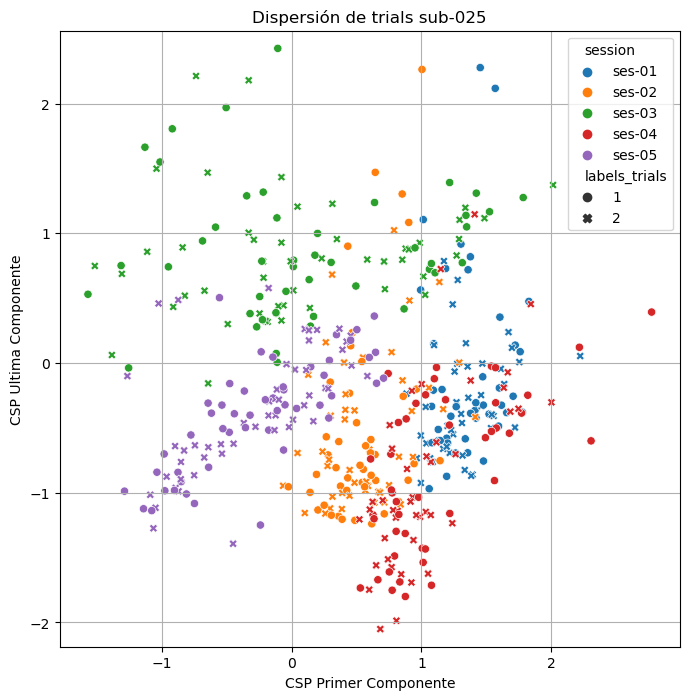

In [13]:
figures_path_root = path_root + "Processing_Figures_001/"
savefig= True
path=figures_path_root
marks=['o','^','s','H','D']
        
for participant in participants: 
    fig, ax = plt.subplots()
    fig.set_size_inches((8,8))
    it=0
    colors = sns.color_palette()
    df = pd.DataFrame()
    for session in sessions:
        df_aux = pd.DataFrame()
        X=registers[participant][session]['data_csp'].T
        N = X.shape[1]
        X_mu = np.array([X[0,:],X[-1,:]]).mean(axis=1)
        X_sigma = np.cov(np.array([X[0,:],X[-1,:]]))
        df_aux['session'] = N*[session]
        df_aux['CSP Primer Componente']=X[0,:]
        df_aux['CSP Ultima Componente']=X[-1,:]
        df_aux['labels_trials'] = registers[participant][session]['labels_trials']
        df = pd.concat([df, df_aux], axis=0)
    
    
    # #Hallamos la media de cada trial de cada se3sion
    # df_aux_1 = df.loc[df['labels_trials'] == 1.]
    # df_aux_    
        
    scatter_plot = sns.scatterplot(data=df, x="CSP Primer Componente", y="CSP Ultima Componente",
                                    hue="session",style='labels_trials')
    scatter_plot.set_title('Dispersión de trials ' + participant)
    scatter_plot.grid(True)
    scatter_plot.set_aspect('equal', adjustable='datalim')
    fig = scatter_plot.figure
    fig.set_size_inches((8,8))
    if savefig:
        fig.savefig(path+participant+'_disp_per_session.png')
    plt.show()
    plt.close() 

In [4]:
# -------------------- Procesamiento-------------------------#
# 1. Dividimos en datos de entrenamiento y testeo
registers.split_database(percent_train = 0.2 , percent_validation=0.8)

In [5]:
# 2. Agrupamos los datos para el entrenamiento y la validacion
registers.group_data()

In [6]:
registers.csp_fit()

NameError: name 'n_comp' is not defined

In [ ]:
# 1. Realizamos CSP
registers.csp(path=figures_path_root,savefig=save_figures)
#plt.close()

#registers.plot_scatter_csp_per_subject(path=figures_path_root,savefig=save_figures)
# 2. Guardamos los datos
#registers.save_registers(path=save_path)

In [ ]:
from Shu_Dataset import SHU_DATASET
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import signal

from fairness.functions import *
from mne.decoding import  CSP

# Cargamos los datos del participante

In [ ]:
participant="sub-001"
session="ses-01"
database_path="Dataset_Preprocessing/"+participant+"/"
data_path=participant+"_"+session+"_task_motorimagery_eeg_preprocessing.mat"

In [ ]:
dataset=SHU_DATASET(path=database_path+data_path,preprocessing=True)

# Filtramos

In [ ]:
l_freq=8
h_freq=40
order=5
dataset.Filter(freq=l_freq, filter_type="highpass", order=order)
dataset.Filter(freq=h_freq, filter_type="lowpass", order=order)

# Realizamos CSP

In [ ]:
DATA =dataset.register['data']
LABELS = np.squeeze(dataset.register['labels_trials'])
n_epochs=DATA.shape[0]

In [ ]:
# Hacemos whitening de los datos
X=np.hstack(DATA)
X_w , W = Whitening(X)
DATA=np.array(np.hsplit(X_w,n_epochs))

In [ ]:
csp = CSP(n_components=6)
#learn csp filters
csp.fit(DATA, LABELS)
DATA_csp=csp.transform(DATA)

# Cargamos todos los archivos 

In [ ]:
participants=["sub-001","sub-002","sub-003","sub-004","sub-005",
              "sub-006","sub-007","sub-008","sub-009","sub-010",
              "sub-011","sub-012","sub-013","sub-014","sub-015",
              "sub-016","sub-017","sub-018","sub-019","sub-020",
              "sub-021","sub-022","sub-023","sub-024","sub-025"]
sessions=["ses-01","ses-02","ses-03","ses-04","ses-05"]

In [ ]:
DATA={}
flag_participant=True

for participant in participants:
    flag_participant=True
    DATA[participant] = {}
    for session in sessions: 
        database_path="Dataset_Preprocessing/"+participant+"/"
        data_path=participant+"_"+session+"_task_motorimagery_eeg_preprocessing.mat"
        data=sio.loadmat(database_path + data_path)
        DATA[participant][session]={}
        DATA[participant][session]['data'] = data['data']
        DATA[participant][session]['labels_trials'] = np.squeeze(data['labels_trials'])
        if flag_participant:
            DATA[participant]['group_medidator']=data['group_medidator']
            DATA[participant]['gender']=data['gender']
            DATA[participant]['id_participant']=data['id_participant']
            DATA[participant]['sfreq']=data['sfreq']
            DATA[participant]['ch_names']=data['ch_names']
            DATA[participant]['age']=data['age']
            DATA[participant]['n_epochs']=data['data'].shape[0]
            DATA[participant]['n_samples']=data['data'].shape[2]
            DATA[participant]['n_chans']=data['data'].shape[1]
            flag_participant = False

# Concatenamos todas las sesiones de un sujeto

In [ ]:
for participant in participants:
    DATA[participant]['data']=np.concatenate((DATA[participant]["ses-01"]['data'],
                                              DATA[participant]["ses-02"]['data'],
                                              DATA[participant]["ses-03"]['data'],
                                              DATA[participant]["ses-04"]['data'],
                                              DATA[participant]["ses-05"]['data']),axis=0)
    DATA[participant]['labels_trials']=np.concatenate((DATA[participant]["ses-01"]['labels_trials'],
                                              DATA[participant]["ses-02"]['labels_trials'],
                                              DATA[participant]["ses-03"]['labels_trials'],
                                              DATA[participant]["ses-04"]['labels_trials'],
                                              DATA[participant]["ses-05"]['labels_trials']))

# Blanqueamos los datos 


In [ ]:
for participant in participants:
    n_epochs = DATA[participant]['data'].shape[0]
    X = np.hstack(DATA[participant]['data'].copy())
    X_w , W = Whitening(X)
    DATA[participant]['data_w'] = np.array(np.hsplit(X_w.copy(),n_epochs))

# ELiminamos variables no usadas

In [ ]:
del X, X_w, W, data

# Realizamos CSP y transformamos los datos

In [ ]:
for participant in participants:
    csp = CSP(n_components=6)
    #Fit CSP with all epochs per participant
    csp.fit(DATA[participant]['data_w'], DATA[participant]['labels_trials'])
    #Transform  CSP with all epochs per participant
    DATA[participant]['data_csp']=csp.transform(DATA[participant]['data_w'])

# Guardamos los datos de CSP

In [ ]:
# Guardamos los datos de CSP
save_path_root = "/home/bruno/Academico/Doctorado/Neuro_Fairness/Shu_Dataset/Dataset_CSP/"
for participant in participants:
    save_path=save_path_root+participant+"_task_motorimagery_eeg_preprocessing_csp.mat"
    data_save={'data_csp':DATA[participant]['data_csp'],
                'labels_trials':DATA[participant]['labels_trials'],
                'sfreq':DATA[participant]['sfreq'],
                'age':DATA[participant]['age'],
                'gender':DATA[participant]['gender'],
                'group_medidator':DATA[participant]['group_medidator'],
                'id_participant':DATA[participant]['id_participant']}
    sio.savemat(save_path, data_save)

--------------------------------------------------------------------------------------------------------

# Calculo de la Divergencia de Kullback-Lleiber Simetrizada

Para esto lo que hacemos es calcular la distancia entre cada par de sujetos paraa tres categorías: Hombre-Hombre ; Mujer-Mujer y Mujer-Hombre

In [2]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
from fairness.functions import *
from mne.decoding import  CSP

In [5]:
dataset_path_root = "/home/bruno/Academico/Doctorado/Neuro_Fairness/Shu_Dataset/002_Dataset_CSP_003/"
participants=["sub-001","sub-002","sub-003","sub-004","sub-005",
              "sub-006","sub-007","sub-008","sub-009","sub-010",
              "sub-011","sub-012","sub-013","sub-014","sub-015",
              "sub-016","sub-017","sub-018","sub-019","sub-020",
              "sub-021","sub-022","sub-023","sub-024","sub-025"]
sessions = ["ses-01","ses-02","ses-03","ses-04","ses-05"]

# Cargamos los datos de csp


In [6]:
dataset={}
for participant in participants:
    dataset[participant]={}
    data_path=participant+"_task_motorimagery_eeg_preprocessing_csp.mat"
    data=sio.loadmat(dataset_path_root + data_path)
    for session in sessions:
        dataset[participant][session +'_data_csp']=data[session +'_data_csp']
        dataset[participant][session +'_labels_trials']=data[session +'_labels_trials']
    dataset[participant]['sfreq']=np.squeeze(data['sfreq'])
    dataset[participant]['age']=np.squeeze(data['age'])
    dataset[participant]['gender']=data['gender'][0]
    dataset[participant]['group_medidator']=data['group_medidator'][0]
    dataset[participant]['id_participant']=data['id_participant'][0]

# Estimamos la media y la matriz de covarianzas para cada participante 

In [ ]:
for participant in participants:
    DATA[participant]['data_csp']=DATA[participant]['data_csp']
    DATA[participant]['mu_csp']=DATA[participant]['data_csp'].mean(axis=1,keepdims=True) # Se puede quitar el keepdims
    DATA[participant]['sigma_csp']=np.cov(DATA[participant]['data_csp'])

In [ ]:
data_plot_csp = DATA[participant]['data_csp']

# Creamos un dataframe con los datos

In [ ]:
DATA_TABLE = pd.DataFrame(DATA).transpose()
DATA_TABLE.reset_index(inplace=True)
DATA_TABLE.rename(columns = {'index':'subject'},inplace = True)
DATA_TABLE

In [ ]:
DATA_TABLE_HH = DATA_TABLE[DATA_TABLE['gender'] == 'M']
DATA_TABLE_MM = DATA_TABLE[DATA_TABLE['gender'] == 'F']

# Para Graficar realizamos reducción de dimensionalidad mediante PCA

In [ ]:
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA

In [ ]:
class pca():
    def __init__(self,X=[]):
        # X is features x samples
        if len(X)!=0:
            self.X_data=X
            self.Fit(X)
            print('PCA')

    def Fit(self,X):  
        self.data=X
        self.mu=np.mean(self.data,axis=1,keepdims=True)
        self.N=X.shape[1]
        self.cov_matrix=(1/self.N)*(X-self.mu)@(X-self.mu).T
        self.eig_values,self.eig_vectors=np.linalg.eigh(self.cov_matrix)
        
        self.eig_values=self.eig_values[::-1]
        self.eig_vectors=self.eig_vectors[:,::-1]
        
        return self.eig_values,self.eig_vectors

    def Project(self,X,n=2,plot=True):
        proj=self.eig_vectors[:,:n].T @ X
        if n==2 and plot==True:
            x1=proj[0,:]
            x2=proj[1,:]
            plt.scatter(x1,x2)
        return proj
    
    def Fit_Transform(X,n_comp=2):
        eig_val,eig_vec = self.Fit(X)
        X_proj = self.Project(X,n=n_comp,plot=False)
        return eig_val, X_proj



In [ ]:
from matplotlib.patches import Ellipse

def Plot_Ellipse_Distribution(mu, sigma,nstd=3. , ax=None,color='red',cmap='viridiris'):
    eig_values, eig_vectors=np.linalg.eigh(sigma)
    order = eig_values.argsort()[::-1]
    eig_values=eig_values[order]
    eig_vectors=eig_vectors[:,order]
    
    #Hallamos el angulo de la ellipse
    theta = np.degrees(np.arctan2(*eig_vectors[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2. * nstd * np.sqrt(eig_values)
    
    
    ellip = Ellipse(xy=mu, width=width, height=height, angle=theta, linewidth=1,facecolor=None,edgecolor=color,fill=None)
    
    ax.add_artist(ellip)
    return ax

In [ ]:
# Aplicamos PCA
data_csp_pca=[]
mu_csp_pca=[]
sigma_csp_pca=[]
eig_val_pca=[]
for it in range(len(DATA_TABLE)):
    X = DATA_TABLE.iloc[it]['data_csp']
    pca_=pca()
    eig_val , _= pca_.Fit(X = X)
    X_proj = pca_.Project(X,n=2,plot=False)
    data_csp_pca.append(X_proj)
    eig_val_pca.append(eig_val)
    mu_csp_pca.append(data_csp_pca[-1].mean(axis=1))
    sigma_csp_pca.append(np.cov(data_csp_pca[-1]))

In [ ]:
# Vemos los eigenvalues
fig,ax = plt.subplots()
a=1
for it in range(len(DATA_TABLE)):  
    x=np.linspace(0,len(eig_val_pca[it]),len(eig_val_pca[it]))
    ax.bar(x,eig_val_pca[it],alpha=a)
    a-=0.005

In [ ]:
index_h=DATA_TABLE.index[DATA_TABLE['gender'] == "M"].tolist()
index_m=DATA_TABLE.index[DATA_TABLE['gender'] == "F"].tolist()

In [ ]:
#Graficamos los datos de hombre
fig , ax = plt.subplots()
fig.set_size_inches((12,12))

n_std=3.
#len(DATA_TABLE)
for it in index_h:
    ax.scatter(data_csp_pca[it][0,:],data_csp_pca[it][1,:],
                   marker='o',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
for it in index_h:
    ax.scatter(mu_csp_pca[it][0],mu_csp_pca[it][1],marker='o',cmap='tab20b',color="C{}".format(it),label=f"H{it}")
    ax = Plot_Ellipse_Distribution(mu_csp_pca[it], sigma_csp_pca[it], nstd =1., ax=ax,color="C{}".format(it))
ax.set_xlabel('X1 pca')
ax.set_ylabel('X2 pca')
ax.set_title('PCA para hombres ')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')


Graficamos los datos de mujeres


In [ ]:
#Graficamos los datos de mujeres
fig , ax = plt.subplots()
fig.set_size_inches((12,12))

n_std=3.
#len(DATA_TABLE)
for it in index_m:
    ax.scatter(data_csp_pca[it][0,:],data_csp_pca[it][1,:],
                   marker='^',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
for it in index_m:
    ax.scatter(mu_csp_pca[it][0],mu_csp_pca[it][1],marker='^',cmap='tab20b',color="C{}".format(it),label=f"M{it}")
    ax = Plot_Ellipse_Distribution(mu_csp_pca[it], sigma_csp_pca[it], nstd =1., ax=ax,color="C{}".format(it))
ax.set_xlabel('X1 pca')
ax.set_ylabel('X2 pca')
ax.set_title('PCA para mujeres ')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')

In [ ]:
it_m, it_h = (index_m[:2], index_h[:2])
print(it_m, it_h )

Graficamos para dos mujeres y dos hombres

In [ ]:
fig , ax = plt.subplots()
fig.set_size_inches((6,6))

n_std=3.
#len(DATA_TABLE)
it=0
for it_m, it_h in (index_m[:2], index_h[:2]):
    ax.scatter(data_csp_pca[it_m][0,:],data_csp_pca[it_m][1,:],
                   marker='^',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
    
    ax.scatter(data_csp_pca[it_h][0,:],data_csp_pca[it_h][1,:],
                   marker='o',cmap='tab20b',color="C{}".format(it+1),facecolors='none',
                   alpha=0.25)
    it+=2

it=0
for it_m, it_h in (index_m[:2], index_h[:2]):
    ax.scatter(mu_csp_pca[it_m][0],mu_csp_pca[it_m][1],
               marker='^',cmap='tab20b',color="C{}".format(it),
               label=f"M{it_m}")
    ax = Plot_Ellipse_Distribution(mu_csp_pca[it_m], sigma_csp_pca[it_m], nstd =1., ax=ax,color="C{}".format(it))
    
    
    ax.scatter(mu_csp_pca[it_h][0],mu_csp_pca[it_h][1],marker='o',cmap='tab20b',color="C{}".format(it+1),label=f"H{it_h}")
    ax = Plot_Ellipse_Distribution(mu_csp_pca[it_h], sigma_csp_pca[it_h], nstd =1., ax=ax,color="C{}".format(it+1))
    it+=2
    
    
it=0

ax.set_xlabel('X1 pca')
ax.set_ylabel('X2 pca')
ax.set_ylim(-4)
ax.set_title('PCA para dos hombres y mujeres ')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')

--------------------------------------------------------------------------
# 2-02-2023


In [7]:
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
from fairness.functions import *
from mne.decoding import  CSP
dataset_path_root = "/home/bruno/Academico/Doctorado/Neuro_Fairness/Shu_Dataset/002_Dataset_CSP_003/"
participants=["sub-001","sub-002","sub-003","sub-004","sub-005",
              "sub-006","sub-007","sub-008","sub-009","sub-010",
              "sub-011","sub-012","sub-013","sub-014","sub-015",
              "sub-016","sub-017","sub-018","sub-019","sub-020",
              "sub-021","sub-022","sub-023","sub-024","sub-025"]
sessions = ["ses-01","ses-02","ses-03","ses-04","ses-05"]
dataset={}
for participant in participants:
    dataset[participant]={}
    data_path=participant+"_task_motorimagery_eeg_preprocessing_csp.mat"
    data=sio.loadmat(dataset_path_root + data_path)
    for session in sessions:
        dataset[participant][session +'_data_csp']=data[session +'_data_csp']
        dataset[participant][session +'_labels_trials']=data[session +'_labels_trials']
    dataset[participant]['sfreq']=np.squeeze(data['sfreq'])
    dataset[participant]['age']=np.squeeze(data['age'])
    dataset[participant]['gender']=data['gender'][0]
    dataset[participant]['group_medidator']=data['group_medidator'][0]
    dataset[participant]['id_participant']=data['id_participant'][0]

In [26]:
dataset_df = pd.DataFrame(dataset).transpose()
dataset_df['participant'] = participants
dataset_df.reset_index(inplace=True)
dataset_df

,index,ses-01_data_csp,ses-01_labels_trials,ses-02_data_csp,ses-02_labels_trials,ses-03_data_csp,ses-03_labels_trials,ses-04_data_csp,ses-04_labels_trials,ses-05_data_csp,ses-05_labels_trials,sfreq,age,gender,group_medidator,id_participant,data_csp,participant
0,sub-001,"[[-0.2973066456520354, 1.9846877757779549, 1.7...","[[1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1,...","[[-1.332394353933741, -0.4797571788611148, -0....","[[1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,...","[[0.0304043014073902, 1.2922397498485, 1.66376...","[[2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1,...","[[0.5296081307754352, 0.8092666032642345, 1.94...","[[2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1,...","[[0.17983938248899947, 3.0799880705953893, 0.9...","[[2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2,...",250,24,[M],[novice],sub-001,"{'all_data': [[-0.2973066456520354, 1.98468777...",sub-001
1,sub-002,"[[0.2691278970564135, 7.762648029474587, 1.886...","[[2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2,...","[[-2.1650897722093663, -0.07122448397371048, -...","[[2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2,...","[[1.6385463004393428, 0.5180359924246418, 2.08...","[[2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1,...","[[-0.4757313878066984, 0.5952528328499923, 2.1...","[[1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1,...","[[-0.6367696070529236, 0.8224861731189868, 0.4...","[[2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2,...",250,24,[M],[novice],sub-002,"{'all_data': [[0.2691278970564135, 7.762648029...",sub-002
2,sub-003,"[[1.9948874398281138, 0.9064874929834307, 1.28...","[[1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1,...","[[1.749892959991536, 1.4166572134450715, 1.985...","[[2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1,...","[[2.0692475973452966, 2.308306903223455, 1.429...","[[1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,...","[[2.0359840551172534, 0.3463777073779604, 1.70...","[[1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2,...","[[2.9753552487416375, 0.6251661297347556, 0.98...","[[1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1,...",250,23,[F],[novice],sub-003,"{'all_data': [[1.9948874398281138, 0.906487492...",sub-003
3,sub-004,"[[1.813839842471705, 1.759402699645635, 2.9485...","[[2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1,...","[[1.1255459880921215, 0.7467334945009091, 1.33...","[[2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1,...","[[2.0353115172093186, -0.4361000653319099, 1.4...","[[1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2,...","[[0.893975436415662, -1.516920407178827, 0.657...","[[1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1,...","[[-0.2714958511251648, -0.3625503755701124, 0....","[[2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,...",250,23,[F],[novice],sub-004,"{'all_data': [[1.813839842471705, 1.7594026996...",sub-004
4,sub-005,"[[-0.9466080041663086, 1.1473675197088058, 0.8...","[[2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1,...","[[0.1878412292795291, 1.930469965602141, 1.285...","[[2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1,...","[[-0.12829185603786217, 0.718912470983005, 1.0...","[[2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1,...","[[2.0092403795062674, 0.5197634496609145, 1.03...","[[2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2,...","[[2.787654624851069, 3.217912295199615, 3.1758...","[[1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,...",250,22,[F],[novice],sub-005,"{'all_data': [[-0.9466080041663086, 1.14736751...",sub-005
5,sub-006,"[[1.8299563452793215, 3.5983752250951735, -0.5...","[[1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1,...","[[-0.9078166449690738, 1.9127204778641065, 2.4...","[[2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,...","[[0.8896933614588342, 1.9860568314018376, 3.72...","[[2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1,...","[[0.13743453468640204, 0.4084386341812126, 1.7...","[[2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1,...","[[1.4569639345218615, 1.3127128711718803, 1.34...","[[1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2,...",250,22,[F],[novice],sub-006,"{'all_data': [[1.8299563452793215, 3.598375225...",sub-006
6,sub-007,"[[1.1094053393882501

In [27]:
index_h=dataset_df.index[dataset_df['gender'] == "M"].tolist()
index_m=dataset_df.index[dataset_df['gender'] == "F"].tolist()

In [28]:
matrix_mean_csp = np.zeros((6,len(participants)))
matrix_cov_csp = np.zeros((6,6,len(participants)))

it=0

for participant in participants:
    data_ = np.concatenate((dataset[participant]['ses-01_data_csp'],
                            dataset[participant]['ses-02_data_csp'],
                            dataset[participant]['ses-03_data_csp'],
                            dataset[participant]['ses-04_data_csp'],
                            dataset[participant]['ses-05_data_csp']),axis=0)
    data_mean_ = np.mean(data_ , axis=0)
    data_cov_ = np.cov(data_.T)
    
    matrix_mean_csp[:,it] = data_mean_
    matrix_cov_csp[:,:,it] = data_cov_
    
    dataset[participant]['data_csp'] = {'all_data' : data_, 'mean': data_mean_, 'cov': data_cov_}
    it+=1

# Eliminar el sujeto cuya media se aleje mas de la media general en hombres

In [66]:
means_male_csp = matrix_mean_csp[:,index_h].copy()
mean_male = means_male_csp.mean(axis=1,keepdims=True)

dist_males_mean = np.linalg.norm(means_male_csp - mean_male,axis = 0)
idx_male_exclude = dist_males_mean.argmax()
print(index_h)
print(f'El sujeto que es excluido del análisis por tener una distancia con respecto a la media es {dataset_df.iloc[index_h[idx_male_exclude],-1]}')
index_h.remove(idx_male_exclude)
print(index_h)

[0, 1, 7, 11, 12, 14, 16, 17, 18, 20, 21, 22, 24]
El sujeto que es excluido del análisis por tener una distancia con respecto a la media es sub-002
[0, 7, 11, 12, 14, 16, 17, 18, 20, 21, 22, 24]


# Calculamos la divergencia de Kullback-Llieber 

Esta medida la realizamos para cada sujeto respecto a los demás

In [67]:
# Definimos la función que calcula la Divergencia de Kullback-Lleiber simetrizada
def Symmetrised_Divergence_KL(mu_p,mu_q,sigma_p,sigma_q):
    k=len(mu_p)
    
    inv_sigma_p=np.linalg.inv(sigma_p)
    inv_sigma_q=np.linalg.inv(sigma_q)
    
    term0_a=(mu_p - mu_q).T
    term0_b=inv_sigma_p + inv_sigma_q
    term0_c=mu_p - mu_q
    term1 = term0_a @ term0_b @ term0_c
    
    term2= np.trace( inv_sigma_q @ sigma_p )
    
    term3=np.trace( inv_sigma_p @ sigma_q )
    
    D_skl =(term1 + term2+ term3  - 2*k)/4
    
    return D_skl

# Estimamos las distancias para los pares de sujetos H-M 

In [68]:
D_KLS=np.zeros((len(participants),len(participants)))
for it0 in range(0,len(participants)-1):
    for it1 in range(it0+1,len(participants)):
        mu_p = matrix_mean_csp[:,it0]
        mu_q = matrix_mean_csp[:,it1]
        sigma_p = matrix_cov_csp[:,:,it0]
        sigma_q = matrix_cov_csp[:,:,it1]
        D_KLS[it0,it1]=Symmetrised_Divergence_KL(mu_p,mu_q,sigma_p,sigma_q)
print(D_KLS)

[[ 0.          2.39277484  7.6503812   4.51685014  6.57681153  6.29301747
   7.60672722  9.03659531  7.9366608   4.01379969  4.2160063   8.66207099
   6.7111792   4.02005317  6.83293882  6.86203546  5.79319541  4.953428
   5.97093242  5.81754647  4.60158903  7.24312149 10.79105896  5.71520601
   5.7852569 ]
 [ 0.          0.         14.69312308  2.63253556  4.34346272  3.97981936
   5.79085628  5.54940056  6.04426416  3.70730618  2.64648824  5.45372226
   7.60237387  5.41163217  4.21810289  6.51602915  8.79332116  6.66874427
   5.71970359  5.70998889  6.21314256  5.72784582  7.73982638  6.44844323
   5.13165036]
 [ 0.          0.          0.         13.62166084 10.79295578 13.54623889
   9.97346269 22.0008359  16.48689502  5.35818024  8.77993194  7.64425653
   4.16074342  9.53712787  9.56573351  8.45304379  7.05664723  2.97573789
   9.11280319 10.03799511  3.42402055 16.07332108 12.63623806  2.94918271
   5.93999874]
 [ 0.          0.          0.          0.          5.49834279  4.6475

In [72]:
from random import sample, shuffle

In [83]:
# Estimamos la divergencia de Kullback-Lleiber
D_KLS_HM = []
for idx_h in index_h:
    for idx_m in index_m:
        if D_KLS[idx_h,idx_m]!=0:
            D_KLS_HM.append(D_KLS[idx_h,idx_m])
            
for idx_m in index_m:
    for idx_h in index_h:
        if D_KLS[idx_m,idx_h]!=0:
            D_KLS_HM.append(D_KLS[idx_m,idx_h])
D_KLS_HM =  sample(D_KLS_HM, 66)
D_KLS_HM=np.array(D_KLS_HM)
D_KLS_HM_=np.array(D_KLS_HM_)

In [84]:
D_KLS_HH = []
for idx_h0 in index_h:
    for idx_h1 in index_h:
        if D_KLS[idx_h0,idx_h1]!=0:
            D_KLS_HH.append(D_KLS[idx_h0,idx_h1])
D_KLS_HH=np.array(D_KLS_HH)


In [85]:
D_KLS_MM = []
for idx_m0 in index_m:
    for idx_m1 in index_m:
        if D_KLS[idx_m0,idx_m1]!=0:
            D_KLS_MM.append(D_KLS[idx_m0,idx_m1])
D_KLS_MM=np.array(D_KLS_MM)

# Realizamos un histograma de las tres medidas

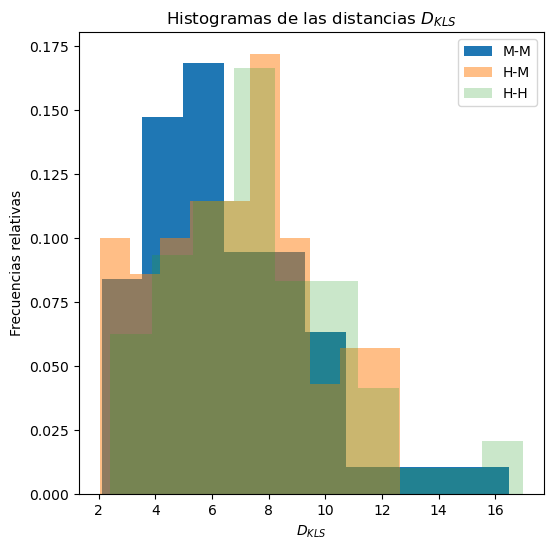

In [86]:
fig,ax=plt.subplots()
fig.set_size_inches((6,6))
ax.hist(D_KLS_MM,label='M-M',density=True,alpha=1)
ax.hist(D_KLS_HM,label='H-M',density=True,alpha=0.5)
ax.hist(D_KLS_HH,label='H-H',density=True,alpha=0.25)

ax.set_xlabel('$D_{KLS}$')
ax.set_ylabel('Frecuencias relativas')
ax.set(title='Histogramas de las distancias $D_{KLS}$')

ax.legend()

# Prueba de Normalidad

In [87]:
# 
from scipy.stats import ks_1samp
from scipy.stats import ttest_1samp
from scipy.stats import wilcoxon
from scipy import stats

In [88]:
alpha = 0.05
alpha_bonferroni = alpha / 3

test_norm = pd.DataFrame(columns=['statistics','p-value','H0'])
comparations = ['M-F','F-F','M-M']

norm_test = ks_1samp(D_KLS_HM,stats.norm.cdf)
if norm_test.pvalue <= alpha_bonferroni:
    test_norm.loc['M-F']=[norm_test.statistic,norm_test.pvalue,False]
else:
    test_norm.loc['M-F']=[norm_test.statistic,norm_test.pvalue,True]


norm_test = ks_1samp(D_KLS_MM,stats.norm.cdf)
if norm_test.pvalue <= alpha_bonferroni:
    test_norm.loc['F-F']=[norm_test.statistic,norm_test.pvalue,False]
else:
    test_norm.loc['F-F']=[norm_test.statistic,norm_test.pvalue,True]


norm_test = ks_1samp(D_KLS_MM,stats.norm.cdf)
if norm_test.pvalue <= alpha_bonferroni:
    test_norm.loc['M-M']=[norm_test.statistic,norm_test.pvalue,False]
else:
    test_norm.loc['M-M']=[norm_test.statistic,norm_test.pvalue,True]

print(f'Significancia: {alpha_bonferroni:.2}')
print(f'Intervalo de confianza: {100*(1-alpha_bonferroni)}')
test_norm

Significancia: 0.017
Intervalo de confianza: 98.33333333333333


,statistics,p-value,H0
M-F,0.982106,9.548257e-116,False
F-F,0.982254,5.524530e-116,False
M-M,0.982254,5.524530e-116,False


# Realizamos un test de Mann Whitney - U


In [89]:
import scipy.stats as st

In [90]:
test = pd.DataFrame(columns=['statics','p-value','H0'])
U_test = st.mannwhitneyu(D_KLS_HM,D_KLS_HH)
if U_test.pvalue <= alpha:
    test.loc['MF - MM']=[U_test.statistic,U_test.pvalue,False]
else: 
    test.loc['MF - MM']=[U_test.statistic,U_test.pvalue,True]

U_test = st.mannwhitneyu(D_KLS_HM,D_KLS_MM)
if U_test.pvalue <= alpha:
    test.loc['MF - FF']=[U_test.statistic,U_test.pvalue,False]
else: 
    test.loc['MF - FF']=[U_test.statistic,U_test.pvalue,True]
    
test

,statics,p-value,H0
MF - MM,1864.0,0.153642,True
MF - FF,2391.0,0.333485,True


In [37]:
def t_test(data0,data1):
    n0=data0.shape[0]
    n1=data1.shape[0]
    mu0=data0.mean()
    mu1=data1.mean()
    var0=np.var(data0)
    var1=np.var(data1)

    t = (mu0-mu1)/np.sqrt(var0/n0 + var1/n1)

    #Estimamos los grados de libertad desbalanceados 

    v =  (var0/n0 + var1/n1) **2 / ( ((var0/n0)**2  / (n0-1)) +  ((var1/n1)**2  / (n1-1)))

    #Distribución t-student
    t_student = st.t(df=v)

    #p-value
    p_value = 2*t_student.cdf(-np.abs(t))
    return t,p_value

Hipotesis Nula: no hay diferencias entre las medias: $μ_{x}=μ_{y}$

In [44]:
table = {}
table['HM - HH'] = {}
table['HM - HH']['t-test'] , table['HM - HH']['p-value'] = t_test(D_KLS_HM,D_KLS_HH)
table['HM - MM'] = {}
table['HM - MM']['t-test'] , table['HM - MM']['p-value'] = t_test(D_KLS_HM,D_KLS_MM)
table['HH - MM'] = {}
table['HH - MM']['t-test'] , table['HH - MM']['p-value'] = t_test(D_KLS_HH,D_KLS_MM)

t_test_table=pd.DataFrame(table).transpose()
t_test_table

,t-test,p-value
HM - HH,-1.465300,0.144801
HM - MM,0.734814,0.463721
HH - MM,1.923889,0.056390


---------------------------------------------------------------------------------------

# Dividimos los datos por el tipo de imagenería motora

In [ ]:
labels = np.unique(DATA['sub-001']['labels_trials'])

for participant in participants:
    data = DATA[participant]['data_csp']
    DATA[participant]['data_csp_class1']=data[:,DATA[participant]['labels_trials'] == labels[0]]
    DATA[participant]['data_csp_class2']=data[:,DATA[participant]['labels_trials'] == labels[1]]
    
    DATA[participant]['mu_csp_class1']=data[:,DATA[participant]['labels_trials'] == labels[0]].mean(axis=1) 
    DATA[participant]['mu_csp_class2']=data[:,DATA[participant]['labels_trials'] == labels[1]].mean(axis=1) # Se puede quitar el keepdims
    DATA[participant]['sigma_csp_class1']=np.cov(data[:,DATA[participant]['labels_trials'] == labels[0]])
    DATA[participant]['sigma_csp_class2']=np.cov(data[:,DATA[participant]['labels_trials'] == labels[1]])
    
DATA_TABLE = pd.DataFrame(DATA).transpose()
DATA_TABLE.reset_index(inplace=True)
DATA_TABLE.rename(columns = {'index':'subject'},inplace = True)
DATA_TABLE

# Graficamos


In [ ]:
# Aplicamos PCA
data_csp_pca_class1=[]
mu_csp_pca_class1=[]
sigma_csp_pca_class1=[]
eig_val_pca_class1=[]
data_csp_pca_class2=[]
mu_csp_pca_class2=[]
sigma_csp_pca_class2=[]
eig_val_pca_class2=[]
for it in range(len(DATA_TABLE)):
    X = DATA_TABLE.iloc[it]['data_csp_class1']
    pca_=pca()
    eig_val , _= pca_.Fit(X = X)
    X_proj = pca_.Project(X,n=2,plot=False)
    data_csp_pca_class1.append(X_proj)
    eig_val_pca_class1.append(eig_val)
    mu_csp_pca_class1.append(data_csp_pca_class1[-1].mean(axis=1))
    sigma_csp_pca_class1.append(np.cov(data_csp_pca_class1[-1]))
    
    X = DATA_TABLE.iloc[it]['data_csp_class2']
    pca_=pca()
    eig_val , _= pca_.Fit(X = X)
    X_proj = pca_.Project(X,n=2,plot=False)
    data_csp_pca_class2.append(X_proj)
    eig_val_pca_class2.append(eig_val)
    mu_csp_pca_class2.append(data_csp_pca_class2[-1].mean(axis=1))
    sigma_csp_pca_class2.append(np.cov(data_csp_pca_class2[-1]))
    
# Vemos los eigenvalues
fig,ax = plt.subplots()
a=1
for it in range(len(DATA_TABLE)):  
    x=np.linspace(0,len(eig_val_pca_class1[it]),len(eig_val_pca_class1[it]))
    ax.bar(x,eig_val_pca_class1[it],alpha=a)
    a-=0.005

fig,ax = plt.subplots()
a=1
for it in range(len(DATA_TABLE)):  
    x=np.linspace(0,len(eig_val_pca_class2[it]),len(eig_val_pca_class2[it]))
    ax.bar(x,eig_val_pca_class2[it],alpha=a)
    a-=0.005



In [ ]:
#Graficamos los datos de hombre
fig , ax = plt.subplots()
fig.set_size_inches((12,12))

n_std=3.
#len(DATA_TABLE)
for it in index_h[1:3]:
    ax.scatter(data_csp_pca_class1[it][0,:],data_csp_pca_class1[it][1,:],
                   marker='o',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
    ax.scatter(data_csp_pca_class2[it][0,:],data_csp_pca_class2[it][1,:],
                   marker='s',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
for it in index_h[1:3]:
    ax.scatter(mu_csp_pca_class1[it][0],mu_csp_pca_class1[it][1],marker='o',cmap='tab20b',color="C{}".format(it),label=f"H{it} class 1")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class1[it], sigma_csp_pca_class1[it], nstd =1., ax=ax,color="C{}".format(it))
    ax.scatter(mu_csp_pca_class2[it][0],mu_csp_pca_class2[it][1],marker='o',cmap='tab20b',color="C{}".format(it),label=f"H{it} class 2")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class2[it], sigma_csp_pca_class2[it], nstd =1., ax=ax,color="C{}".format(it))
    
ax.set_xlabel('X1 pca')
ax.set_ylabel('X2 pca')
ax.set_title('PCA para hombres ')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')

In [ ]:
#Graficamos los datos de mujeres
fig , ax = plt.subplots()
fig.set_size_inches((12,12))

n_std=3.
#len(DATA_TABLE)
for it in index_m[1:3]:
    ax.scatter(data_csp_pca_class1[it][0,:],data_csp_pca_class1[it][1,:],
                   marker='^',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
    ax.scatter(data_csp_pca_class2[it][0,:],data_csp_pca_class2[it][1,:],
                   marker='P',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
for it in index_m[1:3]:
    ax.scatter(mu_csp_pca_class1[it][0],mu_csp_pca_class1[it][1],marker='^',cmap='tab20b',color="C{}".format(it),label=f"M{it} class 1")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class1[it], sigma_csp_pca_class1[it], nstd =1., ax=ax,color="C{}".format(it))
    ax.scatter(mu_csp_pca_class2[it][0],mu_csp_pca_class2[it][1],marker='P',cmap='tab20b',color="C{}".format(it),label=f"M{it} class 2")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class2[it], sigma_csp_pca_class2[it], nstd =1., ax=ax,color="C{}".format(it))
    
ax.set_xlabel('X1 pca')
ax.set_ylabel('X2 pca')
ax.set_title('PCA para mujeres ')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')

In [ ]:
fig , ax = plt.subplots()
fig.set_size_inches((6,6))

n_std=3.
#len(DATA_TABLE)
it=0
for it_m, it_h in (index_m[1:3], index_h[1:3]):
    ax.scatter(data_csp_pca_class1[it_m][0,:],data_csp_pca_class1[it_m][1,:],
                   marker='^',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
    
    ax.scatter(data_csp_pca_class1[it_h][0,:],data_csp_pca_class1[it_h][1,:],
                   marker='o',cmap='tab20b',color="C{}".format(it+1),facecolors='none',
                   alpha=0.25)
    
    ax.scatter(data_csp_pca_class2[it_m][0,:],data_csp_pca_class2[it_m][1,:],
                   marker='P',cmap='tab20b',color="C{}".format(it),facecolors='none',
                   alpha=0.25)
    
    ax.scatter(data_csp_pca_class2[it_h][0,:],data_csp_pca_class2[it_h][1,:],
                   marker='s',cmap='tab20b',color="C{}".format(it+1),facecolors='none',
                   alpha=0.25)
    it+=2

it=0
for it_m, it_h in (index_m[1:3], index_h[1:3]):
    ax.scatter(mu_csp_pca_class1[it_m][0],mu_csp_pca_class1[it_m][1],
               marker='^',cmap='tab20b',color="C{}".format(it),
               label=f"M{it_m} clase 1")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class1[it_m], sigma_csp_pca_class1[it_m], nstd =1., ax=ax,color="C{}".format(it))
    ax.scatter(mu_csp_pca_class2[it_m][0],mu_csp_pca_class2[it_m][1],
               marker='P',cmap='tab20b',color="C{}".format(it),
               label=f"M{it_m} clase 2")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class2[it_m], sigma_csp_pca_class2[it_m], nstd =1., ax=ax,color="C{}".format(it))
    
    ax.scatter(mu_csp_pca_class1[it_h][0],mu_csp_pca_class1[it_h][1],
               marker='o',cmap='tab20b',color="C{}".format(it+1),
               label=f"H{it_h} clase 1")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class1[it_h], sigma_csp_pca_class1[it_h], nstd =1., ax=ax,color="C{}".format(it+1))
    
    ax.scatter(mu_csp_pca_class2[it_h][0],mu_csp_pca_class2[it_h][1],
               marker='s',cmap='tab20b',color="C{}".format(it+1),
               label=f"H{it_h} clase 2")
    ax = Plot_Ellipse_Distribution(mu_csp_pca_class2[it_h], sigma_csp_pca_class2[it_h], nstd =1., ax=ax,color="C{}".format(it+1))
    
    
    it+=2
    
    
it=0

ax.set_xlabel('X1 pca')
ax.set_ylabel('X2 pca')
ax.set_title('PCA para dos hombres y mujeres ')
ax.legend()
ax.set_aspect('equal', adjustable='datalim')

In [ ]:
DATA[participant]['data_csp_class1']=data[:,DATA[participant]['labels_trials'] == labels[0]]
DATA[participant]['data_csp_class2']=data[:,DATA[participant]['labels_trials'] == labels[1]]

DATA[participant]['mu_csp_class1']=data[:,DATA[participant]['labels_trials'] == labels[0]].mean(axis=1) 
DATA[participant]['mu_csp_class2']=data[:,DATA[participant]['labels_trials'] == labels[1]].mean(axis=1) # Se puede quitar el keepdims
DATA[participant]['sigma_csp_class1']=np.cov(data[:,DATA[participant]['labels_trials'] == labels[0]])
DATA[participant]['sigma_csp_class2']

In [ ]:
data_mu_csp_class1= np.zeros((6,len(DATA_TABLE)))
data_sigma_csp_class1 = np.zeros((6,6,len(DATA_TABLE)))
data_mu_csp_class2= np.zeros((6,len(DATA_TABLE)))
data_sigma_csp_class2 = np.zeros((6,6,len(DATA_TABLE)))
for it in range(len(DATA_TABLE)):
    data_mu_csp_class1[:,it]= DATA_TABLE['mu_csp_class1'][it]
    data_sigma_csp_class1[:,:,it]= DATA_TABLE['sigma_csp_class1'][it]
    data_mu_csp_class2[:,it]= DATA_TABLE['mu_csp_class2'][it]
    data_sigma_csp_class2[:,:,it]= DATA_TABLE['sigma_csp_class2'][it]

In [ ]:
D_KLS_class1=np.zeros((len(DATA_TABLE),len(DATA_TABLE)))
D_KLS_class2=np.zeros((len(DATA_TABLE),len(DATA_TABLE)))
for it0 in range(0,len(DATA_TABLE)-1):
    for it1 in range(it0+1,len(DATA_TABLE)):
        mu_p = data_mu_csp_class1[:,it0]
        mu_q = data_mu_csp_class1[:,it1]
        sigma_p = data_sigma_csp_class1[:,:,it0]
        sigma_q = data_sigma_csp_class1[:,:,it1]
        D_KLS_class1[it0,it1]=Symmetrised_Divergence_KL(mu_p,mu_q,sigma_p,sigma_q)
        
        mu_p = data_mu_csp_class2[:,it0]
        mu_q = data_mu_csp_class2[:,it1]
        sigma_p = data_sigma_csp_class2[:,:,it0]
        sigma_q = data_sigma_csp_class2[:,:,it1]
        D_KLS_class2[it0,it1]=Symmetrised_Divergence_KL(mu_p,mu_q,sigma_p,sigma_q)
        
print(D_KLS_class2)

In [ ]:
# Estimamos la divergencia de Kullback-Lleiber
D_KLS_HM_class1 = []
D_KLS_HM_class2 = []
for idx_h in index_h:
    for idx_m in index_m:
        if D_KLS_class1[idx_h,idx_m]!=0.:
            D_KLS_HM_class1.append(D_KLS_class1[idx_h,idx_m])
        if D_KLS_class2[idx_h,idx_m]!=0.:
            D_KLS_HM_class2.append(D_KLS_class2[idx_h,idx_m])
            
for idx_m in index_m:
    for idx_h in index_h:
        if D_KLS_class1[idx_m,idx_h]!=0.:
            D_KLS_HM_class1.append(D_KLS_class1[idx_m,idx_h])
        if D_KLS_class2[idx_m,idx_h]!=0.:
            D_KLS_HM_class2.append(D_KLS_class2[idx_m,idx_h])
            
D_KLS_HM_class1=np.array(D_KLS_HM_class1)
D_KLS_HM_class2=np.array(D_KLS_HM_class2)
print(D_KLS_HM_class1)
print(D_KLS_HM_class2)

In [ ]:
D_KLS_HH_class1 = []
D_KLS_HH_class2 = []
for idx_h0 in index_h:
    for idx_h1 in index_h:
        if D_KLS_class1[idx_h0,idx_h1]!=0:
            D_KLS_HH_class1.append(D_KLS_class1[idx_h0,idx_h1])
        if D_KLS_class2[idx_h0,idx_h1]!=0:
            D_KLS_HH_class2.append(D_KLS_class2[idx_h0,idx_h1])
D_KLS_HH_class1=np.array(D_KLS_HH_class1)
D_KLS_HH_class2=np.array(D_KLS_HH_class2)

In [ ]:
D_KLS_MM_class1 = []
D_KLS_MM_class2 = []
for idx_m0 in index_m:
    for idx_m1 in index_m:
        if D_KLS_class1[idx_m0,idx_m1]!=0:
            D_KLS_MM_class1.append(D_KLS_class1[idx_m0,idx_m1])
        if D_KLS_class2[idx_m0,idx_m1]!=0:
            D_KLS_MM_class2.append(D_KLS_class2[idx_m0,idx_m1])
D_KLS_MM_class1=np.array(D_KLS_MM_class1)
D_KLS_MM_class2=np.array(D_KLS_MM_class2)

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches((6,6))
ax.hist(D_KLS_MM_class1,label='M-M',density=True,alpha=1)
ax.hist(D_KLS_HM_class1,label='H-M',density=True,alpha=0.5)
ax.hist(D_KLS_HH_class1,label='H-H',density=True,alpha=0.25)

ax.set_xlabel('$D_{KLS}$')
ax.set_ylabel('Frecuencias relativas')
ax.set(title='Histogramas de las distancias $D_{KLS}$')
ax.legend()

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches((6,6))
ax.hist(D_KLS_MM_class2,label='M-M',density=True,alpha=1)
ax.hist(D_KLS_HM_class2,label='H-M',density=True,alpha=0.5)
ax.hist(D_KLS_HH_class2,label='H-H',density=True,alpha=0.25)
ax.set_xlabel('$D_{KLS}$')
ax.set_ylabel('Frecuencias relativas')
ax.set(title='Histogramas de las distancias $D_{KLS}$')
ax.legend()

In [ ]:
table = {}
table['HM - HH'] = {}
table['HM - HH']['t-test'] , table['HM - HH']['p-value'] = st.mannwhitneyu(D_KLS_HM_class1,D_KLS_HH_class1)
table['HM - MM'] = {}
table['HM - MM']['t-test'] , table['HM - MM']['p-value'] = st.mannwhitneyu(D_KLS_HM_class1,D_KLS_MM_class1)
table['HH - MM'] = {}
table['HH - MM']['t-test'] , table['HH - MM']['p-value'] = st.mannwhitneyu(D_KLS_HH_class1,D_KLS_MM_class1)

mannwhitneyu_test_table=pd.DataFrame(table).transpose()
mannwhitneyu_test_table

In [ ]:
table = {}
table['HM - HH'] = {}
table['HM - HH']['t-test'] , table['HM - HH']['p-value'] = st.mannwhitneyu(D_KLS_HM_class2,D_KLS_HH_class2)
table['HM - MM'] = {}
table['HM - MM']['t-test'] , table['HM - MM']['p-value'] = st.mannwhitneyu(D_KLS_HM_class2,D_KLS_MM_class2)
table['HH - MM'] = {}
table['HH - MM']['t-test'] , table['HH - MM']['p-value'] = st.mannwhitneyu(D_KLS_HH_class2,D_KLS_MM_class2)

mannwhitneyu_test_table=pd.DataFrame(table).transpose()
mannwhitneyu_test_table